In this notebook you will find:

- Gradient boosted trees implementation
- An improved version of linear regression

In both cases we divided the initial dataset according to the country, so that we obtain a dataset for Germany and another for France. We then modeled according to the country.

In [130]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [131]:
# Here we read the given csvs
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [132]:
# we merge on the ID column, as it will be useful for later
X_train = pd.merge(X_train, Y_train, on='ID')

Here we focus on the gradient boosted trees for Germany

In [133]:
# we keep all the columns that are important for Germany: thus all the columns
# that start with DE and all the gerneral ones

columns_to_keep = ['ID', 'DAY_ID', 'COUNTRY', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'TARGET']
de_columns = [col for col in X_train.columns if col.startswith('DE')]
selected_columns = columns_to_keep + de_columns
X_train_DE = X_train[selected_columns]
X_train_DE = X_train_DE[X_train_DE['COUNTRY']=="DE"]

<ipython-input-134-b005ad273fe1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X_train_DE.corr()


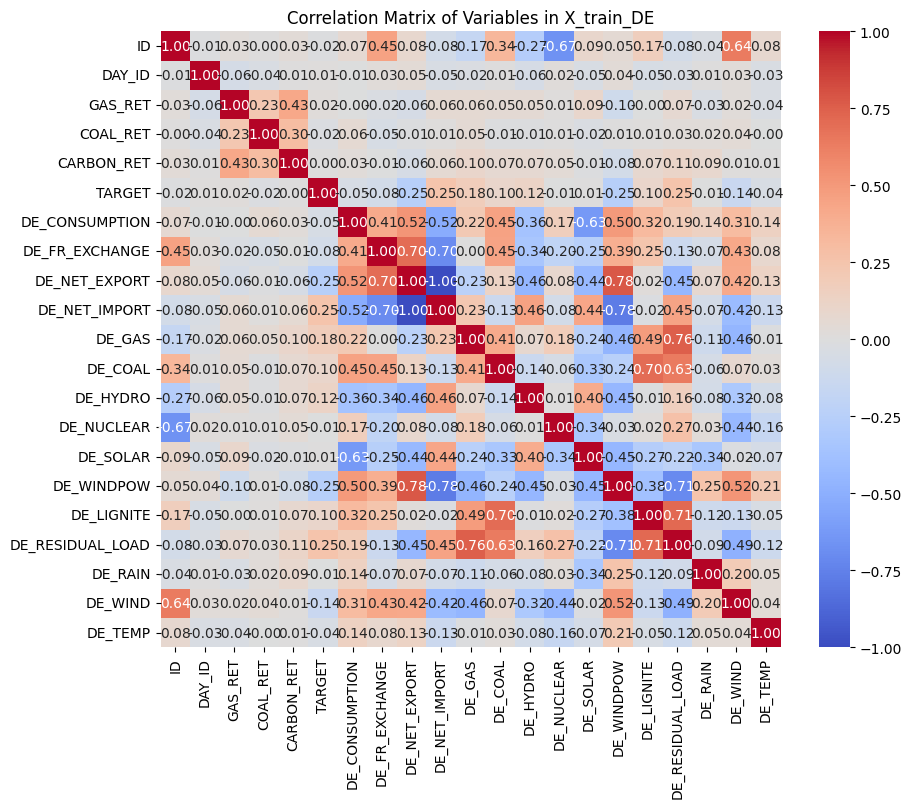

In [134]:
# now we check the correlation between the variables of the dataset and plot
correlation_matrix = X_train_DE.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables in X_train_DE')
plt.show()

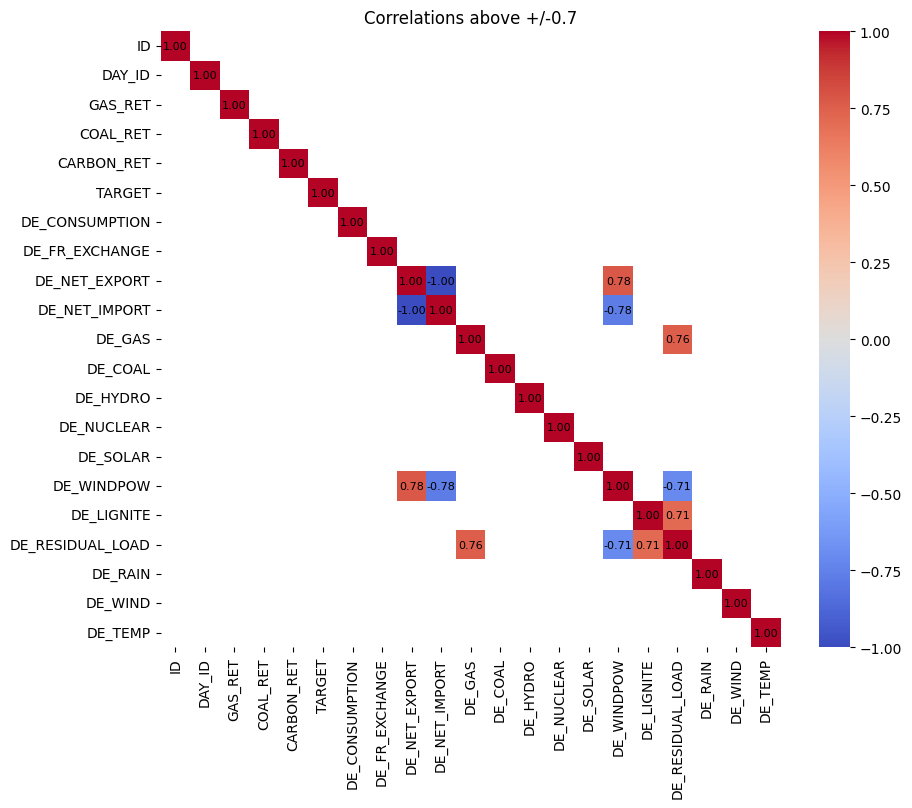

In [135]:
# we set 70% as a threshold to discard the variables
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.70]
plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.7')
plt.show()

In [137]:
# we drop the variables that create multicollinearity issues
X = X_train_DE.drop(['DE_RESIDUAL_LOAD', 'DE_WINDPOW', 'DE_LIGNITE', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT'], axis=1)

In [138]:
X_drop = X
X_drop=X_drop.dropna()

In [139]:
X_drop.isnull().sum()

ID                0
DAY_ID            0
COUNTRY           0
GAS_RET           0
COAL_RET          0
CARBON_RET        0
TARGET            0
DE_CONSUMPTION    0
DE_NET_EXPORT     0
DE_GAS            0
DE_COAL           0
DE_HYDRO          0
DE_NUCLEAR        0
DE_SOLAR          0
DE_RAIN           0
DE_WIND           0
DE_TEMP           0
dtype: int64

In [140]:
Y = X_drop["TARGET"]

In [143]:
X_drop

,ID,DAY_ID,GAS_RET,COAL_RET,CARBON_RET,DE_CONSUMPTION,DE_NET_EXPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_RAIN,DE_WIND,DE_TEMP
3,297,720,0.911652,-0.296168,1.073948,-0.983324,-0.270870,0.487818,-1.473817,-0.368417,-0.205547,1.751523,-1.114838,-0.499409,0.350938
11,819,116,-0.359866,-0.203952,-0.376234,-0.055692,-0.851082,0.882313,-0.042992,1.282374,-2.509255,1.172155,1.608304,1.143607,1.595158
12,918,406,1.170760,0.133643,0.033874,0.532116,-0.173123,-0.188430,-0.354327,-0.168264,-1.879712,-0.324789,-0.194927,1.383171,1.241892
13,283,1175,0.122818,0.220077,5.453331,-0.328286,-1.046122,0.544008,-1.183566,0.523610,-0.646234,0.509242,0.974454,-0.138918,-0.634046
14,158,309,0.689483,1.095473,0.342798,1.028987,-0.391261,2.170761,1.831623,1.223032,0.125765,-1.234093,0.194458,-1.106067,-0.667496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,39,92,0.508669,-0.377857,-1.490871,0.381981,-1.246666,0.480225,-0.715935,2.520682,-0.599819,0.245668,2.310031,-0.239887,0.635275
1485,391,78,0.793561,0.848558,0.517578,0.810509,0.971934,0.187811,-0.605620,0.128621,-0.613791,-0.394101,-0.538831,-0.459455,1.400533
1488,342,87,-0.423802,0.067325,1.558886,-0.295522,-1.969871,1.172127,-0.700021,2.053830,0.028450,0.344296,-1.058410,-0.721643,1.120555
1491,748,1083,-1.112899,-0.237835,0.067152,0.856399,-1.531544,2.108764,1.072553,0.037892,-1.833866,-0.626731,0.207905,-0.594595,0.256338


In [144]:
from sklearn.ensemble import RandomForestRegressor

# now we use random forest to detect the most important variables in our
# regression problem, so that we find the 5 most crucial variables and use them
# in the linear regression model. This should result in an improvement for wrt
# the baseline

X = X_drop
y = Y
rf = RandomForestRegressor()
rf.fit(X, y)
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
n = 5
top_features = importance_df.head(n)
print(top_features)

           Feature  Importance
6    DE_NET_EXPORT    0.120253
13         DE_WIND    0.098005
1           DAY_ID    0.082541
11        DE_SOLAR    0.077353
5   DE_CONSUMPTION    0.072674


In [145]:
# here we keep the most important variables we obtained from the previous section
X_drop=X_drop[['DE_NET_EXPORT', 'DE_WIND', 'DAY_ID', 'DE_SOLAR', 'DE_GAS']]

In [146]:
# we fit the model and calculate the precision of it
X_train, X_test, y_train, y_test = train_test_split(X_drop, Y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.0523490696148265


In [147]:
# now a series of adjustments to X_test in order to be able to make predictions
# with it
X_test = pd.read_csv('X_test.csv')

In [148]:
X_test = X_test[X_test['COUNTRY']=="DE"]

In [149]:
ID = X_test['ID']

In [150]:
X_test=X_test[['DE_NET_EXPORT', 'DE_WIND', 'DAY_ID', 'DE_SOLAR', 'DE_GAS']]

In [151]:
X_test.fillna(0, inplace=True)

In [152]:
X_test.isnull().sum()

DE_NET_EXPORT    0
DE_WIND          0
DAY_ID           0
DE_SOLAR         0
DE_GAS           0
dtype: int64

In [153]:
predictions_DE = lr.predict(X_test)

In [154]:
# these are the predictions for the linear regression wrt to Germany
predictions_DE

array([-2.80373971e-01,  3.80384503e-01, -2.53056547e-01,  4.59622184e-01,
       -9.68472071e-02,  3.89764343e-01, -4.68080130e-02,  5.01222221e-01,
       -3.35219179e-02, -4.06540673e-01, -1.85012661e-01,  6.06580418e-01,
        3.10359585e-01, -6.31793071e-02, -8.79456393e-02, -1.75065406e-01,
        2.10047020e-01,  1.30006326e-01,  4.38267306e-01,  3.78946987e-01,
        2.73432522e-01,  2.69251437e-01, -4.87826093e-01,  4.04837478e-01,
        1.40329311e-01,  4.27046819e-01,  1.42959006e-01,  5.01680706e-02,
        6.04282436e-01, -9.82663661e-02,  2.74440896e-01,  3.13058426e-01,
       -6.72239790e-03, -9.83201788e-02, -2.03724105e-01,  2.33276056e-01,
       -2.19515479e-02, -3.30021452e-03,  6.04985166e-01,  3.28396202e-01,
       -4.39901289e-02, -8.41079220e-04,  3.20308101e-01,  7.95955946e-01,
        1.81027629e-02,  3.88925996e-01,  4.58815798e-01,  4.82633095e-01,
        4.64650697e-01, -1.42285120e-01,  4.99458994e-01,  4.37479082e-01,
        4.01433442e-01,  

In [88]:
predictions_DE.shape

(289,)

In [94]:
predictions_de = pd.DataFrame({'ID': ID, 'TARGET': predictions_DE})

# Now we go over the exact same steps, but with respect to France.

In [159]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [160]:
X_train = pd.merge(X_train, Y_train, on='ID')

In [161]:
columns_to_keep = ['ID', 'DAY_ID', 'COUNTRY', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'TARGET']
fr_columns = [col for col in X_train.columns if col.startswith('FR')]
selected_columns = columns_to_keep + fr_columns
X_train_FR = X_train[selected_columns]
X_train_FR = X_train_FR[X_train_FR['COUNTRY']=="FR"]

<ipython-input-162-190b934ebcde>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X_train_FR.corr()


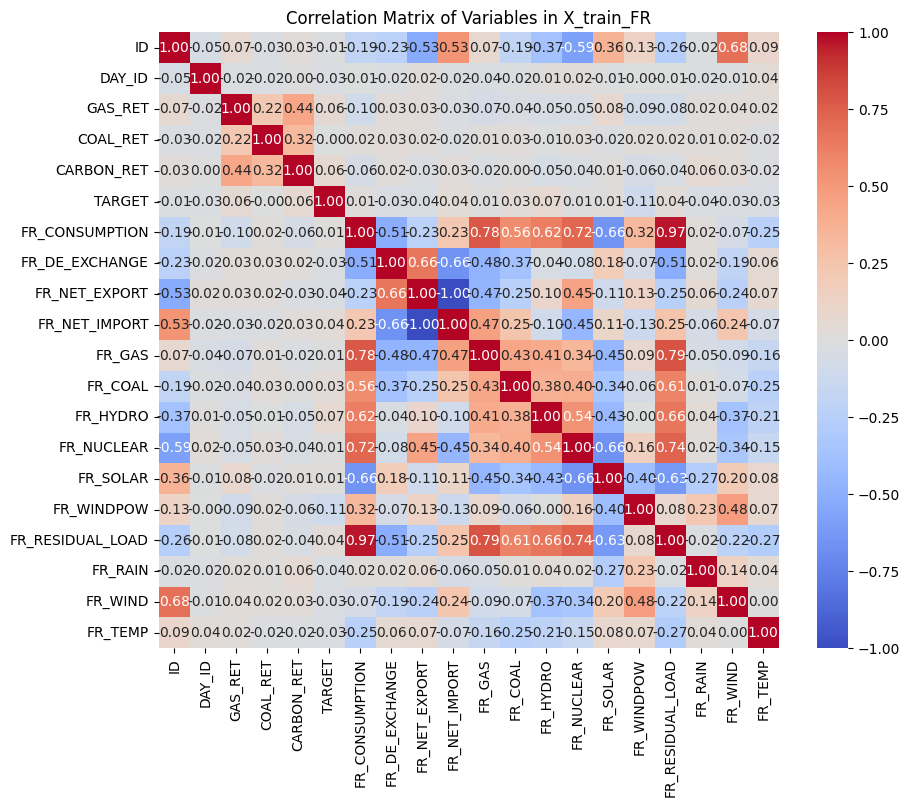

In [162]:
correlation_matrix = X_train_FR.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables in X_train_FR')
plt.show()

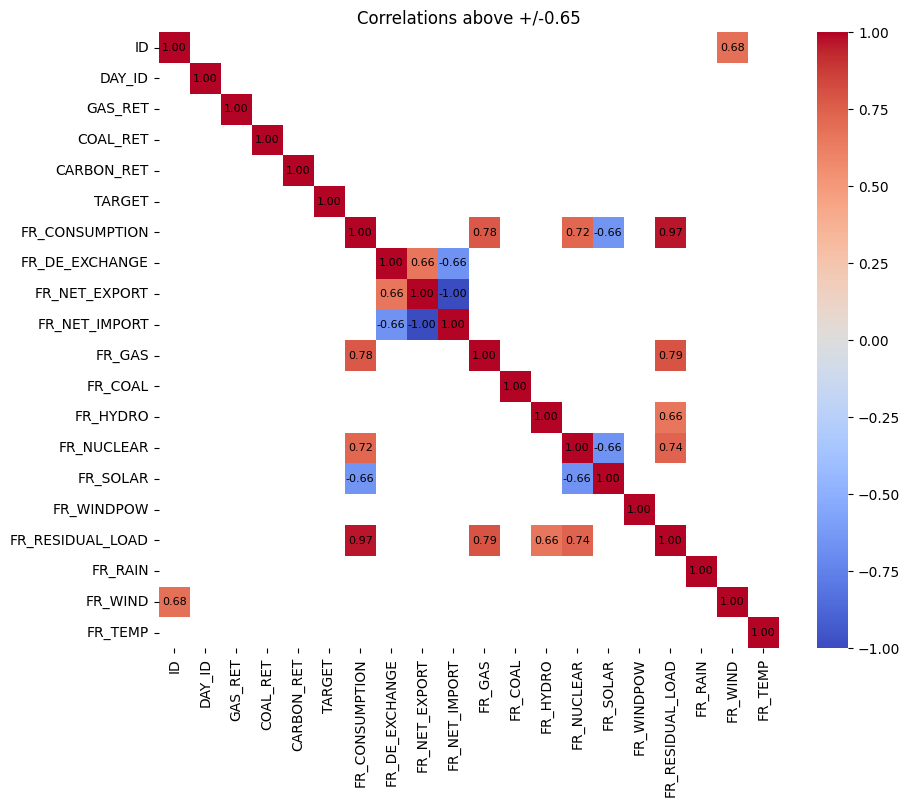

In [163]:
high_correlations = correlation_matrix[correlation_matrix.abs() > 0.65]
plt.figure(figsize=(10, 8))
annot_kws = {"ha": 'center', "va": 'center', "fontsize": 8, "color": 'black'}
sns.heatmap(high_correlations, annot=True, cmap='coolwarm', fmt=".2f", annot_kws=annot_kws)
plt.title('Correlations above +/-0.65')
plt.show()

In [164]:
X = X_train_FR.drop(['FR_RESIDUAL_LOAD', 'FR_CONSUMPTION', 'ID', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'FR_NUCLEAR'], axis=1)

In [165]:
X_drop = X
X_drop=X_drop.dropna()

In [166]:
X_drop.isnull().sum()

DAY_ID           0
COUNTRY          0
GAS_RET          0
COAL_RET         0
CARBON_RET       0
TARGET           0
FR_NET_IMPORT    0
FR_GAS           0
FR_COAL          0
FR_HYDRO         0
FR_SOLAR         0
FR_WINDPOW       0
FR_RAIN          0
FR_WIND          0
FR_TEMP          0
dtype: int64

In [167]:
Y = X_drop["TARGET"]

In [168]:
X_drop = X_drop.drop(["COUNTRY", "TARGET"], axis=1)

In [169]:
X_drop

,DAY_ID,GAS_RET,COAL_RET,CARBON_RET,FR_NET_IMPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_SOLAR,FR_WINDPOW,FR_RAIN,FR_WIND,FR_TEMP
0,206,0.339041,0.124552,-0.002445,-0.692860,-0.213766,0.288782,0.207838,1.248911,-0.269460,-0.556356,-0.283160,-0.063404
1,501,-0.659091,0.047114,-0.490365,1.130838,0.426940,-0.762153,-0.807112,3.237380,-0.107350,-0.770457,0.828412,1.831241
2,687,0.535974,0.743338,0.204952,1.682587,2.122241,0.777053,0.779142,-0.371039,-0.141239,-0.313338,0.487608,0.114836
4,818,0.245109,1.526606,2.614378,-0.990324,-0.240862,-0.274975,-0.795983,0.723587,-0.564498,-0.424550,-1.011560,0.729495
5,467,0.891049,0.861408,1.124457,0.200305,0.306422,-0.775944,0.593251,2.054491,-0.245628,-0.193837,-0.917234,0.472708
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,38,1.596267,1.409234,0.593396,-0.395241,-0.149029,-0.433503,-0.651284,0.374206,0.763672,-0.347173,-0.135046,-1.163299
1483,510,1.946355,0.867074,1.322433,-1.112333,-0.456156,-0.793961,0.538795,1.013134,0.149270,1.021354,0.805043,-0.555211
1486,985,0.494188,1.011794,1.472650,-0.499653,1.320758,-0.779539,0.375729,-1.054641,1.646472,-0.441164,-0.658130,0.829517
1487,905,1.145686,0.335645,0.606318,1.048997,0.715357,-0.305680,-0.188248,1.953376,0.536297,-0.152293,1.697829,-2.069991


In [170]:
X = X_drop
y = Y
rf = RandomForestRegressor()
rf.fit(X, y)
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
n = 5
top_features = importance_df.head(n)
print(top_features)

      Feature  Importance
1     GAS_RET    0.129995
9  FR_WINDPOW    0.101938
5      FR_GAS    0.096671
8    FR_SOLAR    0.095740
3  CARBON_RET    0.089265


In [106]:
X_drop = X_drop[['GAS_RET', 'FR_GAS', 'FR_SOLAR', 'FR_WINDPOW', 'CARBON_RET']]

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_drop, Y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1.0959741567989416


In [116]:
X_test = pd.read_csv('X_test.csv')

In [117]:
X_test = X_test[X_test['COUNTRY']=="FR"]

In [118]:
ID = X_test['ID']

In [119]:
X_test=X_test[['GAS_RET', 'FR_GAS', 'FR_SOLAR', 'FR_WINDPOW', 'CARBON_RET']]

In [112]:
X_test.fillna(0, inplace=True)

In [120]:
X_test.isnull().sum()

GAS_RET       0
FR_GAS        0
FR_SOLAR      0
FR_WINDPOW    0
CARBON_RET    0
dtype: int64

In [121]:
predictions_FR = lr.predict(X_test)

In [122]:
predictions_FR

array([ 0.12705061,  0.19277792, -0.15133743,  0.11676866, -0.062333  ,
        0.30412723, -0.05103924,  0.1401515 ,  0.02362492,  0.14142038,
        0.12140027,  0.20424592,  0.02269569,  0.15325076, -0.21550024,
        0.05208135,  0.02009853, -0.01863953,  0.19127076, -0.02344381,
        0.02450106,  0.09728108, -0.20003967,  0.00209932,  0.04509114,
        0.10745607, -0.05708439, -0.14429013,  0.05628766, -0.13632906,
        0.15126557,  0.1312167 ,  0.07529578,  0.31101425,  0.32637794,
        0.05467383, -0.17672068,  0.05039052,  0.23365838,  0.10868962,
        0.07596033, -0.09356078,  0.04662909,  0.05764661,  0.04713704,
        0.19353675, -0.11866636, -0.00833932,  0.04195012,  0.04959251,
        0.30521424,  0.06482361,  0.02087751,  0.0649497 , -0.07140256,
        0.03292026, -0.3015665 ,  0.14888588,  0.02421876, -0.04093733,
       -0.16173624,  0.02308154,  0.20585587,  0.07801916, -0.06503766,
       -0.10893723,  0.19461238, -0.13914863,  0.1392979 ,  0.05

In [123]:
predictions_FR.shape

(365,)

In [124]:
predictions_fr = pd.DataFrame({'ID': ID, 'TARGET': predictions_FR})

In [127]:
# here we get the final predictions to submit
pred = pd.concat([predictions_fr, predictions_de], axis=0)
pred.to_csv('predictions_LR.csv', index=False)

In [128]:
from google.colab import files
files.download('predictions_LR.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Now we use the Gradient booested tree model

First for France

In [171]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [172]:
X_train = pd.merge(X_train, Y_train, on='ID')

In [173]:
columns_to_keep = ['ID', 'DAY_ID', 'COUNTRY', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'TARGET']
fr_columns = [col for col in X_train.columns if col.startswith('FR')]
selected_columns = columns_to_keep + fr_columns
X_train_FR = X_train[selected_columns]
X_train_FR = X_train_FR[X_train_FR['COUNTRY']=="FR"]

In [174]:
# we drop the columns according to the previous correlation analysis
X = X_train_FR.drop(['FR_RESIDUAL_LOAD', 'FR_CONSUMPTION', 'ID', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'FR_NUCLEAR'], axis=1)

In [175]:
X.isnull().sum()

DAY_ID            0
COUNTRY           0
GAS_RET           0
COAL_RET          0
CARBON_RET        0
TARGET            0
FR_NET_IMPORT    70
FR_GAS            0
FR_COAL           0
FR_HYDRO          0
FR_SOLAR          0
FR_WINDPOW        0
FR_RAIN          47
FR_WIND          47
FR_TEMP          47
dtype: int64

In [176]:
X_drop = X
X_drop=X_drop.dropna()

In [177]:
X_drop.isnull().sum()

DAY_ID           0
COUNTRY          0
GAS_RET          0
COAL_RET         0
CARBON_RET       0
TARGET           0
FR_NET_IMPORT    0
FR_GAS           0
FR_COAL          0
FR_HYDRO         0
FR_SOLAR         0
FR_WINDPOW       0
FR_RAIN          0
FR_WIND          0
FR_TEMP          0
dtype: int64

In [178]:
Y = X_drop["TARGET"]

In [179]:
Y

0       0.028313
1      -0.112516
2      -0.180840
4      -0.071733
5       0.932105
          ...   
1482   -0.094686
1483    0.108277
1486    0.827636
1487    0.049618
1492   -0.640917
Name: TARGET, Length: 734, dtype: float64

In [181]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

In [182]:
X_drop = X_drop.drop(["TARGET", "COUNTRY"], axis=1)

In [183]:
X_drop.replace(['FR', 'DE'], 0, inplace=True)

In [184]:
# we train the model by following the steps:
# - train/test split of the dataset
# - gradient boosting initialization
# - grid search to tune the hyperparameters
# - fitting of the model
# - train the model with the best hyperparameters
# - get the precision of the model
X_train, X_valid, y_train, y_valid = train_test_split(X_drop, Y, test_size=0.2, random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (negative MSE):", best_score)

best_gbr = GradientBoostingRegressor(**best_params, random_state=42)
best_gbr.fit(X_train, y_train)

y_pred = best_gbr.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best Score (negative MSE): -1.1984207028811311
Root Mean Squared Error (RMSE): 1.1396906777862157


In [185]:
X_test = pd.read_csv('/content/X_test.csv')

In [186]:
# here we adjust the variables inside the test dataset and consider only the
# french data

X_test_FR = X_test[X_test['COUNTRY']=="FR"]
X_test_FR = X_test_FR.drop(['FR_RESIDUAL_LOAD', 'FR_CONSUMPTION', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'FR_NUCLEAR'], axis=1)
columns_to_keep = ['ID', 'DAY_ID', 'COUNTRY', 'GAS_RET', 'COAL_RET', 'CARBON_RET']
fr_columns = [col for col in X_test_FR.columns if col.startswith('FR')]
selected_columns = columns_to_keep + fr_columns
X_test_FR = X_test_FR[selected_columns]
X_test_FR = X_test_FR[X_test_FR['COUNTRY']=="FR"]

In [187]:
X_test_FR.isnull().sum()

ID                0
DAY_ID            0
COUNTRY           0
GAS_RET           0
COAL_RET          0
CARBON_RET        0
FR_NET_IMPORT    24
FR_GAS            0
FR_COAL           0
FR_HYDRO          0
FR_SOLAR          0
FR_WINDPOW        0
FR_RAIN          20
FR_WIND          20
FR_TEMP          20
dtype: int64

In [188]:
X_test_FR.fillna(0, inplace=True)

In [189]:
X_test_FR.isnull().sum()

ID               0
DAY_ID           0
COUNTRY          0
GAS_RET          0
COAL_RET         0
CARBON_RET       0
FR_NET_IMPORT    0
FR_GAS           0
FR_COAL          0
FR_HYDRO         0
FR_SOLAR         0
FR_WINDPOW       0
FR_RAIN          0
FR_WIND          0
FR_TEMP          0
dtype: int64

In [190]:
X_test_FR=X_test_FR.drop("COUNTRY", axis=1)

In [191]:
predictions = best_gbr.predict(X_test_FR.drop("ID", axis=1))

In [192]:
predictions

array([ 4.87367775e-02, -6.27328547e-01,  7.15641797e-02,  9.89835302e-02,
       -7.26701479e-03,  7.66568393e-01,  6.22083930e-02,  1.04825294e-01,
       -8.94683230e-02,  1.55300499e-02,  4.71847747e-01,  9.73228242e-02,
        8.59782564e-01, -1.25063315e-01,  6.11251712e-01,  1.69127786e-01,
        3.37901212e-01, -1.57078766e+00,  6.68444123e-01,  1.68612140e-01,
        5.36735387e-02,  5.76000067e-02, -2.10078779e-01, -3.73739911e-02,
        6.18615189e-02,  3.60605184e-01, -8.98549434e-01, -5.66822795e-02,
        4.20588064e-01, -3.25964930e-02, -1.59475918e-01, -3.41679882e-03,
       -1.17034260e-01,  2.26088787e-01,  2.76300816e-01,  3.39144501e-01,
       -1.21420993e-01, -1.35809463e-01,  1.31622567e-01,  1.24452993e-01,
       -7.63370002e-02,  1.22722433e-01, -7.71771793e-03,  7.36329393e-01,
       -5.37614445e-02, -4.20214214e-02, -5.95946990e-01,  5.48935916e-02,
        1.34764952e-01, -1.11467861e-01, -1.07193170e+00, -1.99746787e-02,
        2.57616145e-01, -

In [193]:
predictions.shape

(365,)

In [194]:
predictions_FR = pd.DataFrame({'ID': X_test_FR["ID"], 'TARGET': predictions})

In [195]:
predictions_FR

,ID,TARGET
0,1115,0.048737
1,1202,-0.627329
2,1194,0.071564
3,1084,0.098984
4,1135,-0.007267
...,...,...
635,1341,-0.089711
637,1500,0.411997
639,1340,-0.222025
651,1641,1.247267


Now we go over the same operations but witth respect to Germany data.

In [196]:
X_train = pd.read_csv('X_train.csv')
Y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')

In [197]:
X_train = pd.merge(X_train, Y_train, on='ID')

In [198]:
columns_to_keep = ['ID', 'DAY_ID', 'COUNTRY', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'TARGET']
de_columns = [col for col in X_train.columns if col.startswith('DE')]
selected_columns = columns_to_keep + de_columns
X_train_DE = X_train[selected_columns]
X_train_DE = X_train_DE[X_train_DE['COUNTRY']=="DE"]

In [199]:
X = X_train_DE.drop(['DE_RESIDUAL_LOAD', 'DE_WINDPOW', 'DE_LIGNITE', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT'], axis=1)

In [200]:
X.isnull().sum()

ID                 0
DAY_ID             0
COUNTRY            0
GAS_RET            0
COAL_RET           0
CARBON_RET         0
TARGET             0
DE_CONSUMPTION     0
DE_NET_EXPORT      0
DE_GAS             0
DE_COAL            0
DE_HYDRO           0
DE_NUCLEAR         0
DE_SOLAR           0
DE_RAIN           47
DE_WIND           47
DE_TEMP           47
dtype: int64

In [201]:
X_drop = X
X_drop=X_drop.dropna()

In [202]:
X_drop.isnull().sum()

ID                0
DAY_ID            0
COUNTRY           0
GAS_RET           0
COAL_RET          0
CARBON_RET        0
TARGET            0
DE_CONSUMPTION    0
DE_NET_EXPORT     0
DE_GAS            0
DE_COAL           0
DE_HYDRO          0
DE_NUCLEAR        0
DE_SOLAR          0
DE_RAIN           0
DE_WIND           0
DE_TEMP           0
dtype: int64

In [203]:
Y = X_drop["TARGET"]

In [204]:
X_drop = X_drop.drop(["TARGET", "COUNTRY"], axis=1)

In [205]:
X_drop.replace(['FR', 'DE'], 0, inplace=True)

In [206]:
X_train, X_valid, y_train, y_valid = train_test_split(X_drop, Y, test_size=0.2, random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (negative MSE):", best_score)

best_gbr = GradientBoostingRegressor(**best_params, random_state=42)
best_gbr.fit(X_train, y_train)

y_pred = best_gbr.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best Score (negative MSE): -1.2682446324081038
Root Mean Squared Error (RMSE): 1.0602430610522497


In [207]:
X_test = pd.read_csv('/content/X_test.csv')

In [208]:
# here we adjust the variables inside the test dataset and consider only the
# DE data

X_test_DE = X_test[X_test['COUNTRY']=="DE"]
X_test_DE = X_test_DE.drop(['DE_RESIDUAL_LOAD', 'DE_WINDPOW', 'DE_LIGNITE', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT'], axis=1)
columns_to_keep = ['ID', 'DAY_ID', 'COUNTRY', 'GAS_RET', 'COAL_RET', 'CARBON_RET']
de_columns = [col for col in X_test_DE.columns if col.startswith('DE')]
selected_columns = columns_to_keep + de_columns
X_test_DE = X_test_DE[selected_columns]
X_test_DE = X_test_DE[X_test_DE['COUNTRY']=="DE"]

In [209]:
X_test_DE.isnull().sum()

ID                 0
DAY_ID             0
COUNTRY            0
GAS_RET            0
COAL_RET           0
CARBON_RET         0
DE_CONSUMPTION     0
DE_NET_EXPORT      0
DE_GAS             0
DE_COAL            0
DE_HYDRO           0
DE_NUCLEAR         0
DE_SOLAR           0
DE_RAIN           20
DE_WIND           20
DE_TEMP           20
dtype: int64

In [210]:
X_test_DE.fillna(0, inplace=True)

In [211]:
X_test_DE.isnull().sum()

ID                0
DAY_ID            0
COUNTRY           0
GAS_RET           0
COAL_RET          0
CARBON_RET        0
DE_CONSUMPTION    0
DE_NET_EXPORT     0
DE_GAS            0
DE_COAL           0
DE_HYDRO          0
DE_NUCLEAR        0
DE_SOLAR          0
DE_RAIN           0
DE_WIND           0
DE_TEMP           0
dtype: int64

In [212]:
X_test_DE=X_test_DE.drop("COUNTRY", axis=1)

In [213]:
predictions = best_gbr.predict(X_test_DE)

In [214]:
predictions

array([-8.92076031e-01,  3.14502701e-01, -2.55783137e-01,  2.75337831e-01,
        7.24814103e-02,  7.02232986e-02,  4.84281465e-03,  1.22417613e-01,
       -5.94382939e-02, -3.74916165e-01, -3.39084400e-02,  7.14730222e-01,
        1.42912821e-01,  4.16395155e-01,  7.83089268e-02, -6.59550853e-03,
        6.45007990e-02,  2.04390991e-01,  4.19785676e-01,  1.93112489e-01,
        3.22198640e-01, -1.40052673e-01, -2.01310100e+00,  4.30671004e-01,
       -7.67697924e-03,  8.51739419e-01,  7.26682189e-02,  7.20766391e-03,
        5.31450461e-01,  4.44714839e-01,  3.26112138e-01,  2.29616140e-01,
        1.34782169e-01,  1.99388911e-01, -2.07980640e-01,  3.18198015e-01,
       -1.49306504e-01, -6.16240700e-02,  4.51936533e-01,  2.46567171e-01,
       -1.06610367e-01,  7.32832461e-02,  1.47477365e-01,  7.48955581e-01,
        1.50808346e-02,  2.46211015e-01,  5.22412791e-01,  6.20572296e-01,
        1.10924493e-01,  1.41437224e+00,  8.27416847e-01,  6.51645777e-01,
        1.97126713e-01,  

In [215]:
predictions.shape

(289,)

In [217]:
predictions_DE = pd.DataFrame({'ID': X_test_DE["ID"], 'TARGET': predictions})

In [218]:
predictions_DE

,ID,TARGET
182,730,-0.892076
183,273,0.314503
184,911,-0.255783
185,274,0.275338
186,619,0.072481
...,...,...
647,450,0.851540
648,817,0.331697
649,879,-1.050855
650,673,0.114788


In [ ]:
pred = pd.concat([predictions_FR, predictions_DE], axis=0)
pred.to_csv('predictions.csv', index=False)

In [ ]:
from google.colab import files
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>